# Show Ratio Holo/Ronchi for HD205905

Calculate the ratio of hologram transmission wrt Ronchi 

- author Sylvie Dagoret-Campagne
- creation date : May 2018
- affliliation : CNRS/IN2P3
- project : DESC-LSST


- need to increase the number of files to be open:

    ulimit -a
    
    ulimit -n 2048
    
    ulimit -Sn 10000

In [1]:
!ulimit -a

core file size          (blocks, -c) 0
data seg size           (kbytes, -d) unlimited
file size               (blocks, -f) unlimited
max locked memory       (kbytes, -l) unlimited
max memory size         (kbytes, -m) unlimited
open files                      (-n) 2048
pipe size            (512 bytes, -p) 1
stack size              (kbytes, -s) 8192
cpu time               (seconds, -t) unlimited
max user processes              (-u) 1418
virtual memory          (kbytes, -v) unlimited


## Setup

### Notebook style

In [2]:
from IPython.core.display import HTML
def css_styling():
    styles = open("../../styles/custom.css", "r").read()
    return HTML(styles)
css_styling()

In [3]:
from locale import *
setlocale(LC_NUMERIC, '') 

'en_US.UTF-8'

### import

In [4]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx

import sys
import os
import pandas as pd
import glob
from matplotlib.backends.backend_pdf import PdfPages 

In [5]:
from scipy import interpolate

In [6]:
import seaborn as sns

In [7]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

### Figure style

In [8]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 10),   #defines the default image size
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [9]:
plt.rcParams.update({'figure.max_open_warning': 0}) # to see a large number of files

## Initialisation

### Spectractor

In [10]:
PATH_SPECTRACTOR='../../../Spectractor'
PATH_SPECTRACTORSIM='../../../SpectractorSim'
PATH_SPECTRACTORANAATM='../../../SpectractorAnaAtm/common_tools'
PATH_GMAOMERRA='../../../merra2'

In [11]:
sys.path.append(PATH_SPECTRACTOR)
sys.path.append(PATH_SPECTRACTORSIM)
sys.path.append(PATH_SPECTRACTORANAATM)
sys.path.append(PATH_GMAOMERRA)

In [12]:
from spectractor import *
from spectractorsim import *
from libspecana import *

## Input spectra

### LogBook

In [13]:
file_logbook_csv=os.path.join(PATH_SPECTRACTOR,'ctiofulllogbook_jun2017_v4.csv')

In [14]:
df_ctio_lbk=pd.read_csv(file_logbook_csv,sep=';')

In [15]:
df_ctio_lbk.columns

Index([u'Unnamed: 0', u'date', u'subdir', u'index', u'object', u'filter',
       u'disperser', u'airmass', u'exposure', u'focus', u'seeing', u'P', u'T',
       u'RH', u'W', u'file', u'Obj-posXpix', u'Obj-posYpix', u'Dx', u'Dy',
       u'comment', u'skip'],
      dtype='object')

In [16]:
df_ctio_lbk=df_ctio_lbk.reindex(columns=['date','index','P','T','RH','airmass','seeing','exposure','object','filter','disperser','focus','W','subdir','file']).set_index('date').sort_index()

### Spectra Data

In [17]:
home=os.getenv('HOME')

In [18]:
print home

/Users/dagoret


In [19]:
path_data=os.path.join(home,'DATA/CTIODataJune2017_reduced_RG715_v2_prod2')
#path_data=os.path.join('/sps/lsst/data/AtmosphericCalibration','CTIODataJune2017_reduced_RG715_v2_prod1')

In [20]:
All_Subdirs=np.array(['data_28may17','data_29may17','data_30may17','data_31may17','data_01jun17','data_02jun17',
            'data_03jun17','data_04jun17','data_06jun17','data_08jun17','data_09jun17','data_10jun17',
            'data_12jun17','data_13jun17'])

In [21]:
Flag_Photometric_Nights=np.array([False,False,True,False,False,False,False,False,False,True,False,True,True,False])

In [22]:
photometric_indexes=np.where(Flag_Photometric_Nights)[0]

In [23]:
print 'Photometric indexes : ',photometric_indexes

Photometric indexes :  [ 2  9 11 12]


In [24]:
print 'Photometric nights : ',All_Subdirs[photometric_indexes]

Photometric nights :  ['data_30may17' 'data_08jun17' 'data_10jun17' 'data_12jun17']


### Sim spectra

In [25]:
PATH_SPECTRACTORSIM

'../../../SpectractorAnaAtm/common_tools/../../SpectractorSim'

In [26]:
# laptop:
path_sim=os.path.join(PATH_SPECTRACTORSIM,'sim_prod/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra')
# CCIN2P3:
#path_sim=PATH_SPECTRACTORSIM+'/sim_prod/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra'
# Office desktop
home=os.getenv('HOME')
path_sim=os.path.join(home,'DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra_v2')

In [27]:
path_sim

'/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra_v2'

## Selection of night

In [28]:
date="20170530"

In [29]:
idx_sel_subdir=2

In [30]:
SelectTagRe='^reduc_%s_([0-9]+)_spectrum.fits$' % (date)

### Logbook

In [31]:
all_obs=df_ctio_lbk.loc[(df_ctio_lbk["subdir"]==All_Subdirs[idx_sel_subdir])].sort_index()

In [32]:
all_obs_extr=all_obs[["index","object"]]

### Wavelength correction

In [33]:
FLAG_WL_CORRECTION=True # specify if correction on wavelength can be performed from input file
file_wavelengthshift="../wavelength_shift.csv"
wlshift=pd.read_csv(file_wavelengthshift)

### input spectra files

In [34]:
path_spectra=os.path.join(path_data,All_Subdirs[idx_sel_subdir])

In [35]:
search_string=os.path.join(path_spectra,'*.fits')
all_spectrafiles=glob.glob(search_string)
all_spectrafiles=sorted(all_spectrafiles)

In [36]:
all_spectrafiles[:5]

['/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod2/data_30may17/reduc_20170530_057_spectrum.fits',
 '/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod2/data_30may17/reduc_20170530_058_spectrum.fits',
 '/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod2/data_30may17/reduc_20170530_060_spectrum.fits',
 '/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod2/data_30may17/reduc_20170530_061_spectrum.fits',
 '/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod2/data_30may17/reduc_20170530_062_spectrum.fits']

### extract the index from the data spectra filename

In [37]:
#SelectTagRe='^reduc_%s_([0-9]+)_spectrum.fits$' % (date)
all_sel_indexes=[]
for ffn in all_spectrafiles:
    all_sel_indexes.append(get_index_from_filename(ffn,SelectTagRe))
all_sel_indexes=np.array(all_sel_indexes)    

### extract the logbook rows corrsponding to the spectra

- use the indexes obtained to extract the relevant rows from the logbook

In [38]:
sel_obs=all_obs.loc[all_obs['index'].isin(all_sel_indexes)]

In [39]:
sel_obs.head()

,index,P,T,RH,airmass,seeing,exposure,object,filter,disperser,focus,W,subdir,file
date,,,,,,,,,,,,,,
2017-05-31T00:00:26.147,57,783,"9,3",26,"1,053","1,14",60,HD111980,dia,Ron400,12450,"5,7",data_30may17,reduc_20170530_057.fits
2017-05-31T00:02:18.596,58,783,"9,3",26,"1,051","0,94",60,HD111980,dia,Thor300,12450,"5,5",data_30may17,reduc_20170530_058.fits
2017-05-31T00:06:14.000,60,783,"9,1",26,"1,047","1,018",60,HD111980,dia,Ron400,12450,"5,7",data_30may17,reduc_20170530_060.fits
2017-05-31T00:08:06.454,61,783,"9,2",26,"1,045","0,939",60,HD111980,dia,Thor300,12450,"5,5",data_30may17,reduc_20170530_061.fits
2017-05-31T00:09:58.852,62,783,"9,1",26,"1,044","0,846",60,HD111980,dia,HoloPhP,12450,"5,8",data_30may17,reduc_20170530_062.fits


In [40]:
sel_obs.tail()

,index,P,T,RH,airmass,seeing,exposure,object,filter,disperser,focus,W,subdir,file
date,,,,,,,,,,,,,,
2017-05-31T10:33:46.896,280,782,11,20,"1,018","0,793",60,HD205905,dia,Ron400,12400,"14,5",data_30may17,reduc_20170530_280.fits
2017-05-31T10:35:39.245,281,782,"11,2",20,"1,019","0,793",60,HD205905,dia,Thor300,12400,"13,1",data_30may17,reduc_20170530_281.fits
2017-05-31T10:37:31.598,282,782,11,20,"1,021","0,793",60,HD205905,dia,HoloPhP,12400,"12,5",data_30may17,reduc_20170530_282.fits
2017-05-31T10:39:24.046,283,782,11,20,"1,022","0,793",120,HD205905,dia,HoloPhAg,12400,"12,8",data_30may17,reduc_20170530_283.fits
2017-05-31T10:42:16.450,284,782,11,20,"1,024","0,793",120,HD205905,dia,HoloAmAg,12400,"13,2",data_30may17,reduc_20170530_284.fits


### Quick view on the kind of sources

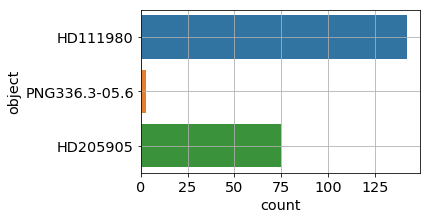

In [41]:
plt.figure(figsize=(5,3))
sns.countplot(y='object', data=sel_obs)
plt.grid(True)

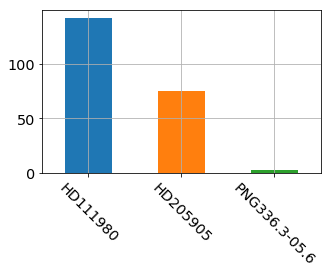

In [42]:
plt.figure(figsize=(5,3))
sel_obs['object'].value_counts().plot(kind='bar',rot=0)
plt.xticks(rotation=-45)
plt.grid(True)

### Remove bad spectrum

In [43]:
bad_obs_0=sel_obs.loc[sel_obs['index'].isin([57])]

In [44]:
bad_obs_0

,index,P,T,RH,airmass,seeing,exposure,object,filter,disperser,focus,W,subdir,file
date,,,,,,,,,,,,,,
2017-05-31T00:00:26.147,57,783,"9,3",26,"1,053","1,14",60,HD111980,dia,Ron400,12450,"5,7",data_30may17,reduc_20170530_057.fits


### Remove bad sources

- remove star **PNG336.3-05.6**

In [45]:
bad_obs=sel_obs.loc[sel_obs['object'].isin(['PNG336.3-05.6','HD111980'])]
bad_indexes=bad_obs["index"]

In [46]:
bad_obs

,index,P,T,RH,airmass,seeing,exposure,object,filter,disperser,focus,W,subdir,file
date,,,,,,,,,,,,,,
2017-05-31T00:00:26.147,57,783,"9,3",26,"1,053","1,14",60,HD111980,dia,Ron400,12450,"5,7",data_30may17,reduc_20170530_057.fits
2017-05-31T00:02:18.596,58,783,"9,3",26,"1,051","0,94",60,HD111980,dia,Thor300,12450,"5,5",data_30may17,reduc_20170530_058.fits
2017-05-31T00:06:14.000,60,783,"9,1",26,"1,047","1,018",60,HD111980,dia,Ron400,12450,"5,7",data_30may17,reduc_20170530_060.fits
2017-05-31T00:08:06.454,61,783,"9,2",26,"1,045","0,939",60,HD111980,dia,Thor300,12450,"5,5",data_30may17,reduc_20170530_061.fits
2017-05-31T00:09:58.852,62,783,"9,1",26,"1,044","0,846",60,HD111980,dia,HoloPhP,12450,"5,8",data_30may17,reduc_20170530_062.fits
2017-05-31T00:11:51.243,63,783,"8,9",26,"1,042","0,83",120,HD111980,dia,HoloPhAg,12450,"5,4",data_30may17,reduc_20170530_063.fits
2017-05-31T00:14:43.647,64,783,"8,9",26,"1,04","0,74",120,HD111980,dia,HoloAmAg,12450,"5,3",data_30may17,reduc_20170530_064.fits
2017-05-31T00:17:36.001,65,783,"8,8",26,"1,037","0,771",60,HD111980,dia,Ron400,12450,"5,4",data_30may17,reduc_20170530_065.fits
2017-05-31T00:19:28.503,66,783,"8,8",26,"1,036","0,715",60,HD111980,dia,Thor300,12450,"4,8",data_30may17,reduc_20170530_066.fits


In [47]:
bad_indexes=bad_obs.loc[:,"index"]

In [48]:
bad_indexes.index

Index([u'2017-05-31T00:00:26.147', u'2017-05-31T00:02:18.596',
       u'2017-05-31T00:06:14.000', u'2017-05-31T00:08:06.454',
       u'2017-05-31T00:09:58.852', u'2017-05-31T00:11:51.243',
       u'2017-05-31T00:14:43.647', u'2017-05-31T00:17:36.001',
       u'2017-05-31T00:19:28.503', u'2017-05-31T00:21:20.951',
       ...
       u'2017-05-31T05:07:24.403', u'2017-05-31T05:10:16.753',
       u'2017-05-31T05:13:09.206', u'2017-05-31T05:15:01.551',
       u'2017-05-31T05:16:53.954', u'2017-05-31T05:18:46.349',
       u'2017-05-31T05:21:38.803', u'2017-05-31T05:56:35.901',
       u'2017-05-31T06:05:21.701', u'2017-05-31T07:03:12.652'],
      dtype='object', name=u'date', length=145)

In [49]:
bad_indexes.values

array([ 57,  58,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,
        71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
        84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,
        97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109,
       110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122,
       123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135,
       136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148,
       149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161,
       162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174,
       175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187,
       188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200,
       201, 205])

### Concatenate bad obs

In [50]:
bad_obs=pd.concat([bad_obs,bad_obs_0])

In [51]:
bad_obs.sort_values(by="index",inplace=True)

In [52]:
bad_indexes=bad_obs.loc[:,"index"]

In [53]:
bad_indexes.values

array([ 57,  57,  58,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
        70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,
        83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,
        96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108,
       109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121,
       122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134,
       135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147,
       148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160,
       161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173,
       174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186,
       187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199,
       200, 201, 205])

- keep stars **HD111980**, **HD205905**

In [54]:
sel2_obs=sel_obs.loc[sel_obs['object'].isin(['HD205905'])]

In [55]:
sel2_obs=sel2_obs[sel2_obs["index"] !=57]      # REMOVE 57

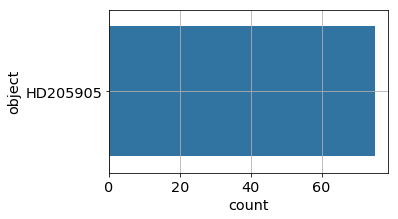

In [56]:
plt.figure(figsize=(5,3))
sns.countplot(y='object', data=sel2_obs)
plt.grid(True)

#### Make a list of the object names

In [57]:
list_of_objects=sel2_obs['object'].values

In [58]:
list_of_objects=set(list_of_objects)

In [59]:
list_of_objects=list(list_of_objects)

In [60]:
list_of_objects_str=','.join(list_of_objects)

# Remove bad indexes

In [61]:
file_toremove=[]
SelectTagRe='^reduc_%s_([0-9]+)_spectrum.fits$' % (date)
for ffn in all_spectrafiles:
    fn=ffn.split('/')[-1]
    sel_index= int(re.findall(SelectTagRe,fn)[0])
    if sel_index in bad_indexes.values:
        print ' remove ', fn
        file_toremove.append(ffn)
for f in file_toremove:
    all_spectrafiles.remove(f)        

 remove  reduc_20170530_057_spectrum.fits
 remove  reduc_20170530_058_spectrum.fits
 remove  reduc_20170530_060_spectrum.fits
 remove  reduc_20170530_061_spectrum.fits
 remove  reduc_20170530_062_spectrum.fits
 remove  reduc_20170530_063_spectrum.fits
 remove  reduc_20170530_064_spectrum.fits
 remove  reduc_20170530_065_spectrum.fits
 remove  reduc_20170530_066_spectrum.fits
 remove  reduc_20170530_067_spectrum.fits
 remove  reduc_20170530_068_spectrum.fits
 remove  reduc_20170530_069_spectrum.fits
 remove  reduc_20170530_070_spectrum.fits
 remove  reduc_20170530_071_spectrum.fits
 remove  reduc_20170530_072_spectrum.fits
 remove  reduc_20170530_073_spectrum.fits
 remove  reduc_20170530_074_spectrum.fits
 remove  reduc_20170530_075_spectrum.fits
 remove  reduc_20170530_076_spectrum.fits
 remove  reduc_20170530_077_spectrum.fits
 remove  reduc_20170530_078_spectrum.fits
 remove  reduc_20170530_079_spectrum.fits
 remove  reduc_20170530_080_spectrum.fits
 remove  reduc_20170530_081_spectr

# which filters

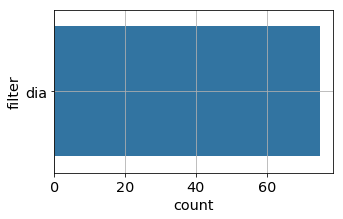

In [62]:
plt.figure(figsize=(5,3))
sns.countplot(y='filter', data=sel2_obs)
plt.grid(True)

# which are the dispersers ?

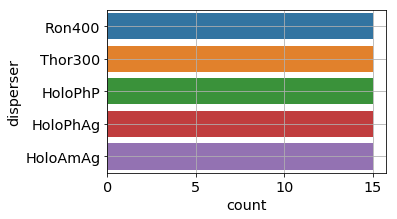

In [63]:
plt.figure(figsize=(5,3))
sns.countplot(y='disperser', data=sel2_obs)
plt.grid(True)

## Get indexes for each disperser

In [64]:
sel_obs_Ron400=sel2_obs.loc[sel2_obs['disperser'].isin(['Ron400'])]

In [65]:
sel_obs_Thor300=sel2_obs.loc[sel2_obs['disperser'].isin(['Thor300'])]

In [66]:
sel_obs_HoloPhP=sel2_obs.loc[sel2_obs['disperser'].isin(['HoloPhP'])]

In [67]:
sel_obs_HoloPhAg=sel2_obs.loc[sel2_obs['disperser'].isin(['HoloPhAg'])]

In [68]:
sel_obs_HoloAmAg=sel2_obs.loc[sel2_obs['disperser'].isin(['HoloAmAg'])]

# Associate Hologram observation to each Ronchi observation

In [69]:
sel_obs_Ron400.head()

,index,P,T,RH,airmass,seeing,exposure,object,filter,disperser,focus,W,subdir,file
date,,,,,,,,,,,,,,
2017-05-31T07:54:38.806,210,782,"9,5",23,"1,101","0,793",60,HD205905,dia,Ron400,12400,"11,6",data_30may17,reduc_20170530_210.fits
2017-05-31T08:06:00.847,215,782,"9,6",23,"1,08","0,793",60,HD205905,dia,Ron400,12400,"15,4",data_30may17,reduc_20170530_215.fits
2017-05-31T08:17:22.698,220,782,"9,6",23,"1,063","0,793",60,HD205905,dia,Ron400,12400,"10,7",data_30may17,reduc_20170530_220.fits
2017-05-31T08:28:44.549,225,782,"9,6",23,"1,048","0,793",60,HD205905,dia,Ron400,12400,15,data_30may17,reduc_20170530_225.fits
2017-05-31T08:40:06.801,230,782,"9,7",23,"1,035","0,793",60,HD205905,dia,Ron400,12400,"11,4",data_30may17,reduc_20170530_230.fits


In [70]:
sel_obs_HoloPhP.head()

,index,P,T,RH,airmass,seeing,exposure,object,filter,disperser,focus,W,subdir,file
date,,,,,,,,,,,,,,
2017-05-31T07:58:23.653,212,782,"9,5",24,"1,094","0,793",60,HD205905,dia,HoloPhP,12400,"10,5",data_30may17,reduc_20170530_212.fits
2017-05-31T08:09:45.655,217,782,"9,8",23,"1,074","0,793",60,HD205905,dia,HoloPhP,12400,"10,8",data_30may17,reduc_20170530_217.fits
2017-05-31T08:21:07.405,222,782,"9,6",23,"1,057","0,793",60,HD205905,dia,HoloPhP,12400,"12,1",data_30may17,reduc_20170530_222.fits
2017-05-31T08:32:29.446,227,782,"9,6",23,"1,043","0,793",60,HD205905,dia,HoloPhP,12400,"14,8",data_30may17,reduc_20170530_227.fits
2017-05-31T08:43:51.549,232,782,"9,9",23,"1,031","0,793",60,HD205905,dia,HoloPhP,12400,"12,5",data_30may17,reduc_20170530_232.fits


In [71]:
sel_obs_HoloPhAg.head()

,index,P,T,RH,airmass,seeing,exposure,object,filter,disperser,focus,W,subdir,file
date,,,,,,,,,,,,,,
2017-05-31T08:00:16.053,213,782,"9,7",23,"1,09","0,793",120,HD205905,dia,HoloPhAg,12400,12,data_30may17,reduc_20170530_213.fits
2017-05-31T08:11:37.854,218,782,"9,6",23,"1,071","0,793",120,HD205905,dia,HoloPhAg,12400,"12,5",data_30may17,reduc_20170530_218.fits
2017-05-31T08:22:59.809,223,782,"9,8",23,"1,055","0,793",120,HD205905,dia,HoloPhAg,12400,"10,2",data_30may17,reduc_20170530_223.fits
2017-05-31T08:34:21.908,228,782,"9,8",23,"1,041","0,793",120,HD205905,dia,HoloPhAg,12400,"14,1",data_30may17,reduc_20170530_228.fits
2017-05-31T08:45:44.007,233,782,10,23,"1,029","0,793",120,HD205905,dia,HoloPhAg,12400,"10,7",data_30may17,reduc_20170530_233.fits


In [72]:
sel_obs_HoloAmAg.head()

,index,P,T,RH,airmass,seeing,exposure,object,filter,disperser,focus,W,subdir,file
date,,,,,,,,,,,,,,
2017-05-31T08:03:08.495,214,782,"9,6",23,"1,085","0,793",120,HD205905,dia,HoloAmAg,12400,"13,4",data_30may17,reduc_20170530_214.fits
2017-05-31T08:14:30.301,219,782,"9,7",23,"1,067","0,793",120,HD205905,dia,HoloAmAg,12400,14,data_30may17,reduc_20170530_219.fits
2017-05-31T08:25:52.205,224,782,"9,6",23,"1,051","0,793",120,HD205905,dia,HoloAmAg,12400,"13,8",data_30may17,reduc_20170530_224.fits
2017-05-31T08:37:14.395,229,782,"9,8",23,"1,038","0,793",120,HD205905,dia,HoloAmAg,12400,"11,4",data_30may17,reduc_20170530_229.fits
2017-05-31T08:48:36.303,234,782,10,22,"1,027","0,793",120,HD205905,dia,HoloAmAg,12400,"13,9",data_30may17,reduc_20170530_234.fits


# function definition

In [73]:
def GetClosestTimeObservation(timestamp0,df_ref):
    """
    for a given timestamp find the closest observation in df_ref
    """ 
    # decode the time form timestamp
    year0=timestamp0.year
    month0=timestamp0.month
    day0=timestamp0.days_in_month
    hour0=timestamp0.hour
    minu0=timestamp0.minute
    
    # convert the string into timestamp in the reference dataset
    #-------------------------------------
    all_datetime=pd.to_datetime(df_ref.index.get_values())

    # get time difference between timestamp = timestamp0-time in reference dataset
    #---------------------------------------
    deltat=(all_datetime-timestamp0).total_seconds()
    delays=np.abs(deltat)
    
    #print delays
    
    idx=np.where(delays==delays.min())[0][0]
        
    #print 'deltat :' ,deltat[idx], pd.Timedelta(deltat[idx],unit='s')
    #print df_ref.iloc[idx,:]
        
    #return a pandas series
    return df_ref.iloc[idx,:]

In [74]:
def GetReferenceIndexes(dataset,dataset_ref):
    """
    function : GetReferenceIndexes(dataset,dataset_ref)
    
    For all observations in dataset, find the corresponding observations in the reference dataset in dataset_ref
    input:
        dataset : dataset for which one want to find the reference in the other dataset
        dataset_ref : dataset of reference (Here the Ronchi)
    output:
        zipped indexes of both datasets
    
    """
    all_indexes=[]
    all_indexes_ref=[]
    
    for time_index, row in dataset.iterrows():    
        #print 'Holo :' ,time_index,row["index"]
        all_indexes.append(row["index"])
    
        ref_obs=GetClosestTimeObservation(pd.to_datetime(time_index),dataset_ref)
        #print '\t ==> Ron reference obs :',ref_obs.name,' ' ,ref_obs["index"]
        all_indexes_ref.append(ref_obs["index"])
    
    all_indexes=np.array(all_indexes)
    all_indexes_ref=np.array(all_indexes_ref)
    
    return zip(all_indexes,all_indexes_ref)

# Find the closest observations in the reference dataset

## Make index pairs

In [75]:
Thor_Ron_indexes=GetReferenceIndexes(sel_obs_Thor300,sel_obs_Ron400)

In [76]:
HoloPhP_Ron_indexes=GetReferenceIndexes(sel_obs_HoloPhP,sel_obs_Ron400)

In [77]:
HoloPhAg_Ron_indexes=GetReferenceIndexes(sel_obs_HoloPhAg,sel_obs_Ron400)

In [78]:
HoloAmAg_Ron_indexes=GetReferenceIndexes(sel_obs_HoloAmAg,sel_obs_Ron400)

## Make time delay 

In [79]:
all_datetime_Thor=pd.to_datetime(sel_obs_Thor300.index.get_values())
all_deltatime_Thor=(all_datetime_Thor-all_datetime_Thor[0]).total_seconds()

In [80]:
all_datetime_HoloPhP=pd.to_datetime(sel_obs_HoloPhP.index.get_values())
all_deltatime_HoloPhP=(all_datetime_HoloPhP-all_datetime_HoloPhP[0]).total_seconds()

In [81]:
all_datetime_HoloPhAg=pd.to_datetime(sel_obs_HoloPhAg.index.get_values())
all_deltatime_HoloPhAg=(all_datetime_HoloPhAg-all_datetime_HoloPhAg[0]).total_seconds()

In [82]:
all_datetime_HoloAmAg=pd.to_datetime(sel_obs_HoloAmAg.index.get_values())
all_deltatime_HoloAmAg=(all_datetime_HoloAmAg-all_datetime_HoloAmAg[0]).total_seconds()

## Make airmass

In [83]:
#def Convert_InFloat(arr_str):
#    """
#    In the logbook the decimal point is converted into a comma.
#    Then one need to replace the coma by a decimal point and then convert the string into a number
#    """
#    arr=[ atof(x.replace(",",".")) for x in arr_str]
#    arr=np.array(arr)
#    return arr

In [84]:
airmass_Thor=Convert_InFloat(sel_obs_Thor300["airmass"].values)

In [85]:
airmass_HoloPhP=Convert_InFloat(sel_obs_HoloPhP["airmass"].values)

In [86]:
airmass_HoloPhAg=Convert_InFloat(sel_obs_HoloPhAg["airmass"].values)

In [87]:
airmass_HoloAmAg=Convert_InFloat(sel_obs_HoloAmAg["airmass"].values)

Text(0.5,1,'airmass vs time')

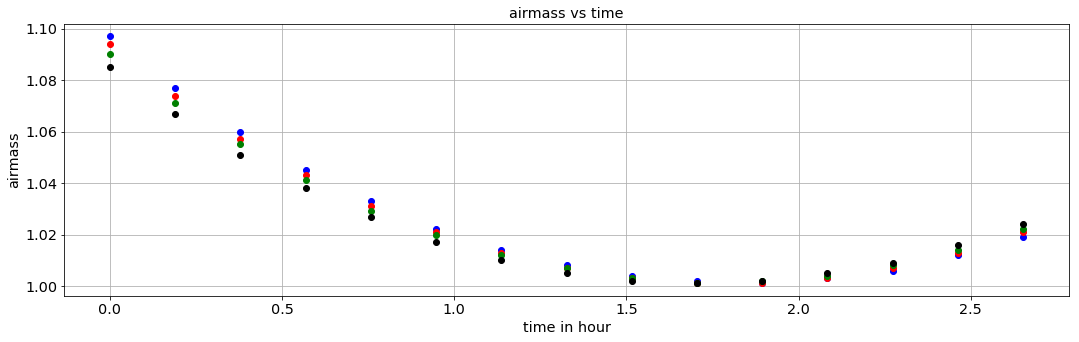

In [88]:
plt.figure(figsize=(18,5))
plt.plot(all_deltatime_Thor/3600.,airmass_Thor,'bo')
plt.plot(all_deltatime_HoloPhP/3600.,airmass_HoloPhP,'ro')
plt.plot(all_deltatime_HoloPhAg/3600.,airmass_HoloPhAg,'go')
plt.plot(all_deltatime_HoloAmAg/3600.,airmass_HoloAmAg,'ko')
plt.grid(True)
plt.xlabel("time in hour")
plt.ylabel("airmass")
plt.title("airmass vs time")

# Show the ratio

In [89]:
def PlotSpectraRatio(the_index_pair,the_sel_obs,color_idx,the_title,XMIN=0,XMAX=0,YMIN=0,YMAX=0,figfilename="figoutput.pdf",Flag_corr_wl=False):
    """
    Function PlotSpectraRatio(the_index_pair,the_sel_obs,the_title,time_color)
    
    input:
        the_index_pair : index pairs
        the_sel_obs    : the logbook
        the_title      : title of the plot 
        time_color     : time in seconds used for color
    
    """    
    
    jet = cm = plt.get_cmap('jet') 
    #cNorm  = colors.Normalize(vmin=color_idx[0], vmax=color_idx[-1])
    cNorm  = colors.Normalize(vmin=color_idx.min(), vmax=color_idx.max())
    
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    #print scalarMap.get_clim()
    
    plt.figure(figsize=(15,10))
    # loop on indexes paris
    
    idx=0
    
    for idx1,idx2 in the_index_pair:
    
        df1=the_sel_obs[sel_obs["index"]==idx1]
        df2=the_sel_obs[sel_obs["index"]==idx2]
        
        filename1=df1.get_value(df1.index[0],"file")  # get "reduc_20170530_213.fits"
        filename2=df2.get_value(df2.index[0],"file")
        
        filename1_cut=filename1.split('.')[0]         # get "reduc_20170530_213
        filename2_cut=filename2.split('.')[0]
        
        filename1=filename1_cut+'_spectrum.fits'
        filename2=filename2_cut+'_spectrum.fits'
        
        #print idx1,idx2,filename1,filename2
        
        #filename1=filename1.replace('reduc','specsim')
        #filename2=filename2.replace('reduc','specsim')
        
    
        ffilename1=os.path.join(path_spectra,filename1)
        ffilename2=os.path.join(path_spectra,filename2)
       
        #print idx1,idx2,ffilename1,ffilename2
    
        hdu1 = fits.open(ffilename1)
        
        if FLAG_WL_CORRECTION and Flag_corr_wl:
            time_correction1=wlshift[wlshift["index"]==idx1].loc[:,"wlshift"].values[0]
        else:
            time_correction1=0
        
        
        data1=hdu1[0].data
        wl1=data1[0]+time_correction1
        fl1=data1[1]
            
        # extend range for (wl1,fl1)
        wl1=np.insert(wl1,0,WL[0])
        fl1=np.insert(fl1,0,0.)
            
        wl1=np.append(wl1,WL[-1])
        fl1=np.append(fl1,0.)
        func1 = interpolate.interp1d(wl1, fl1)
            
        hdu2 = fits.open(ffilename2)
        
        if FLAG_WL_CORRECTION and Flag_corr_wl:
            time_correction2=wlshift[wlshift["index"]==idx2].loc[:,"wlshift"].values[0]
        else:
            time_correction2=0
        
        data2=hdu2[0].data
        wl2=data2[0]+time_correction2
        fl2=data2[1]
        
        # extend range for (wl2,fl2)
        wl2=np.insert(wl2,0,WL[0])
        fl2=np.insert(fl2,0,0.)
        wl2=np.append(wl2,WL[-1])
        fl2=np.append(fl2,0.)
            
        func2 = interpolate.interp1d(wl2, fl2)
        
        fl1_int=func1(WL)
        fl2_int=func2(WL)
        
        the_label=str(idx1)+'/'+str(idx2)
        

        colorVal = scalarMap.to_rgba(color_idx[idx])
        
        plt.plot(WL,2.5*np.log10(fl1_int/fl2_int),lw=2,color=colorVal,label=the_label)
        
        idx+=1
        
    plt.grid()    
    plt.title(the_title,fontsize=30,fontweight='bold')
    plt.xlabel("$\lambda$ (nm)", fontsize=25,fontweight='bold')   
    plt.ylabel("log10(spectra ratio)",fontsize=25,fontweight='bold' )
    if YMIN !=0 or YMAX !=0: 
        plt.ylim(YMIN,YMAX)
    if XMIN !=0 or XMAX !=0: 
        plt.xlim(XMIN,XMAX)
    # We change the fontsize of minor ticks label 
    plt.tick_params(axis='both', which='major', labelsize=25)
    plt.tick_params(axis='both', which='minor', labelsize=10)
    plt.legend()
    plt.savefig(figfilename)

In [90]:
def PlotSpectraRatioSum(the_index_pair,the_sel_obs,color_idx,the_title,XMIN=0,XMAX=0,YMIN=0,YMAX=0,figfilename="figoutput.pdf",Flag_corr_wl=False):
    """
    Function PlotSpectraRatio(the_index_pair,the_sel_obs,the_title,time_color)
    
    input:
        the_index_pair : index pairs
        the_sel_obs    : the logbook
        the_title      : title of the plot 
        time_color     : time in seconds used for color
    
    """        
    all_sum_ratio=[]
    all_X=[]
    
    idx=0
    
    for idx1,idx2 in the_index_pair:
    
        df1=the_sel_obs[sel_obs["index"]==idx1]
        df2=the_sel_obs[sel_obs["index"]==idx2]
        
        filename1=df1.get_value(df1.index[0],"file")  # get "reduc_20170530_213.fits"
        filename2=df2.get_value(df2.index[0],"file")
        
        filename1_cut=filename1.split('.')[0]         # get "reduc_20170530_213
        filename2_cut=filename2.split('.')[0]
        
        filename1=filename1_cut+'_spectrum.fits'
        filename2=filename2_cut+'_spectrum.fits'
        
        #print idx1,idx2,filename1,filename2
        
        #filename1=filename1.replace('reduc','specsim')
        #filename2=filename2.replace('reduc','specsim')
        
    
        ffilename1=os.path.join(path_spectra,filename1)
        ffilename2=os.path.join(path_spectra,filename2)
       
        #print idx1,idx2,ffilename1,ffilename2
    
        if FLAG_WL_CORRECTION and Flag_corr_wl:
            time_correction1=wlshift[wlshift["index"]==idx1].loc[:,"wlshift"].values[0]
        else:
            time_correction1=0
        
        hdu1 = fits.open(ffilename1)
        data1=hdu1[0].data
        wl1=data1[0]+time_correction1
        fl1=data1[1]
        
        
            
        # extend range for (wl1,fl1)
        wl1=np.insert(wl1,0,WL[0])
        fl1=np.insert(fl1,0,0.)
            
        wl1=np.append(wl1,WL[-1])
        fl1=np.append(fl1,0.)
        func1 = interpolate.interp1d(wl1, fl1)
          
        if FLAG_WL_CORRECTION and Flag_corr_wl:
            time_correction2=wlshift[wlshift["index"]==idx2].loc[:,"wlshift"].values[0]
        else:
            time_correction2=0    
        
        hdu2 = fits.open(ffilename2)
        data2=hdu2[0].data
        wl2=data2[0]+time_correction2
        fl2=data2[1]
        
        # extend range for (wl2,fl2)
        wl2=np.insert(wl2,0,WL[0])
        fl2=np.insert(fl2,0,0.)
        wl2=np.append(wl2,WL[-1])
        fl2=np.append(fl2,0.)
            
        func2 = interpolate.interp1d(wl2, fl2)
        
        fl1_int=func1(WL)
        fl2_int=func2(WL)
        
        the_label=str(idx1)+'/'+str(idx2)  
    
        all_X.append(idx1)
        the_diff=2.5*(np.log10(fl1_int)-np.log10(fl2_int))
        the_diff = the_diff[np.isfinite(the_diff)]
        the_sum=np.average(the_diff)
        all_sum_ratio.append(the_sum)

        idx+=1
        
    plt.figure(figsize=(15,6))  
    plt.plot(all_X,all_sum_ratio,'ro')
    plt.plot(all_X,all_sum_ratio,'b-')
    plt.grid()    
    plt.title(the_title,fontsize=30,fontweight='bold')
    plt.xlabel("X", fontsize=25,fontweight='bold')   
    plt.ylabel("sum of log10(spectra ratio)",fontsize=25,fontweight='bold' )
    #if YMIN !=0 or YMAX !=0: 
    #    plt.ylim(YMIN,YMAX)
    #if XMIN !=0 or XMAX !=0: 
    #    plt.xlim(XMIN,XMAX)
    # We change the fontsize of minor ticks label 
    plt.tick_params(axis='both', which='major', labelsize=25)
    plt.tick_params(axis='both', which='minor', labelsize=10)
    plt.legend()
    plt.savefig(figfilename)

## Ratio color indexed by time 

/Users/dagoret/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/dagoret/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/dagoret/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:30: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/dagoret/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:31: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/dagoret/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:97: RuntimeWarning: invalid value encountered in divide


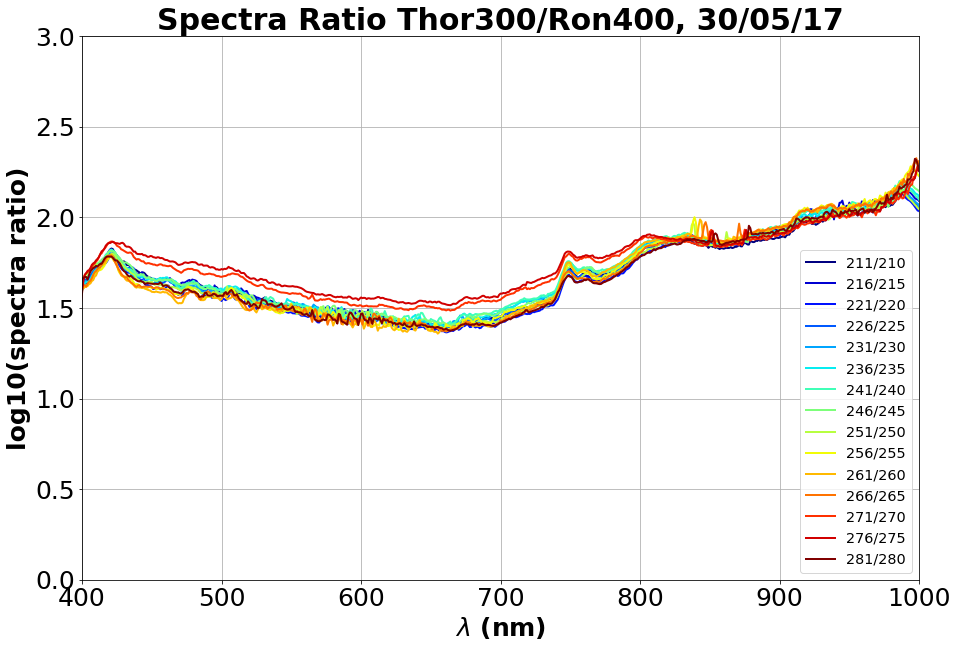

In [91]:
PlotSpectraRatio(Thor_Ron_indexes,sel2_obs,all_deltatime_Thor,
                 "Spectra Ratio Thor300/Ron400, 30/05/17",XMIN=400.,XMAX=1000.,YMIN=0,YMAX=3,figfilename='Thor300DivRon400.pdf',Flag_corr_wl=True)

/Users/dagoret/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/dagoret/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/dagoret/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:22: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/dagoret/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:23: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/dagoret/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:86: RuntimeWarning: divide by zero encountered in log10
/Users/dagoret/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:86: RuntimeWarning: invalid value encountered in subtract
2018-05-17 12:30:21,143 

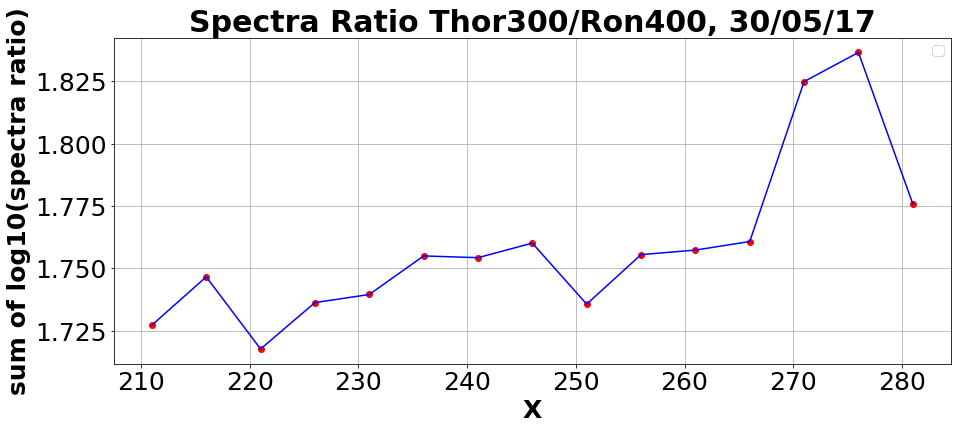

In [92]:
PlotSpectraRatioSum(Thor_Ron_indexes,sel2_obs,all_deltatime_Thor,
                 "Spectra Ratio Thor300/Ron400, 30/05/17",figfilename='Thor300DivRon400_2.pdf',Flag_corr_wl=True)

/Users/dagoret/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/dagoret/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/dagoret/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:30: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/dagoret/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:31: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/dagoret/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:97: RuntimeWarning: invalid value encountered in divide


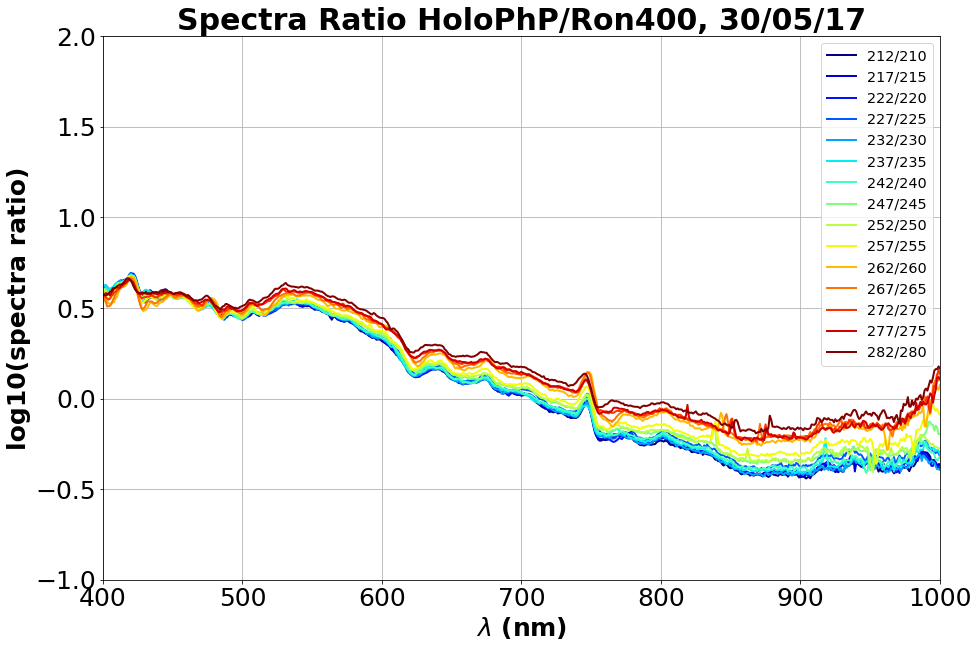

In [93]:
PlotSpectraRatio(HoloPhP_Ron_indexes,sel2_obs,all_deltatime_HoloPhP,
                 "Spectra Ratio HoloPhP/Ron400, 30/05/17",XMIN=400.,XMAX=1000.,YMIN=-1,YMAX=2,figfilename='HoloPhPDivRon400_idxtime.pdf',Flag_corr_wl=True)

/Users/dagoret/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/dagoret/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/dagoret/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:22: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/dagoret/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:23: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/dagoret/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:86: RuntimeWarning: divide by zero encountered in log10
/Users/dagoret/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:86: RuntimeWarning: invalid value encountered in subtract
2018-05-17 12:30:23,480 

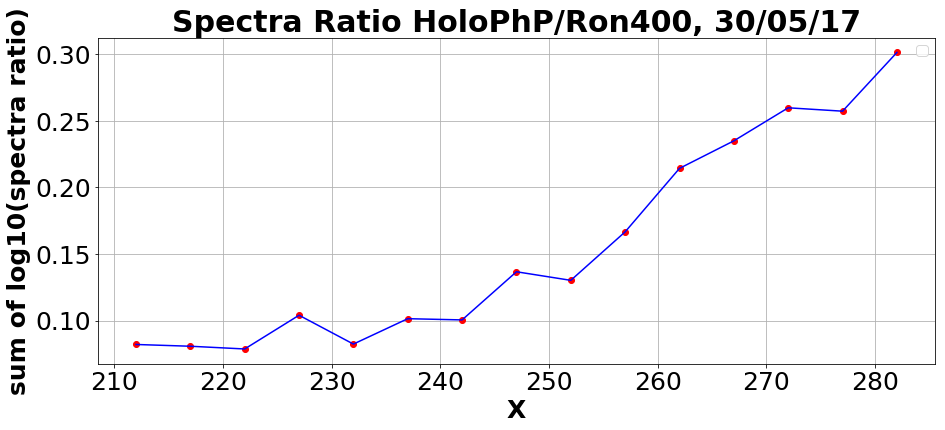

In [94]:
PlotSpectraRatioSum(HoloPhP_Ron_indexes,sel2_obs,all_deltatime_HoloPhP,
                 "Spectra Ratio HoloPhP/Ron400, 30/05/17",figfilename='THoloPhPDivRon400_idxtime_2.pdf',Flag_corr_wl=True)

In [95]:
airmass_HoloPhP

array([ 1.094,  1.074,  1.057,  1.043,  1.031,  1.021,  1.013,  1.007,
        1.003,  1.001,  1.001,  1.003,  1.007,  1.013,  1.021])

/Users/dagoret/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/dagoret/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/dagoret/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:30: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/dagoret/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:31: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/dagoret/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:97: RuntimeWarning: invalid value encountered in divide


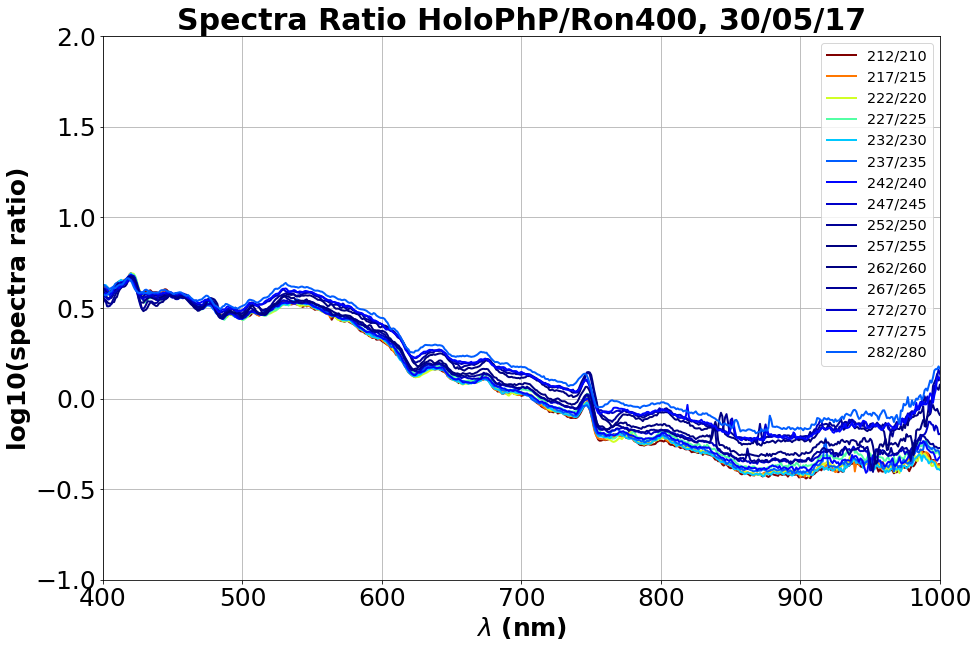

In [96]:
PlotSpectraRatio(HoloPhP_Ron_indexes,sel2_obs,airmass_HoloPhP,
                 "Spectra Ratio HoloPhP/Ron400, 30/05/17",XMIN=400.,XMAX=1000.,YMIN=-1,YMAX=2,figfilename='HoloPhPDivRon400_idxam.pdf',Flag_corr_wl=True)

/Users/dagoret/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/dagoret/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/dagoret/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:30: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/dagoret/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:31: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/dagoret/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:97: RuntimeWarning: invalid value encountered in divide


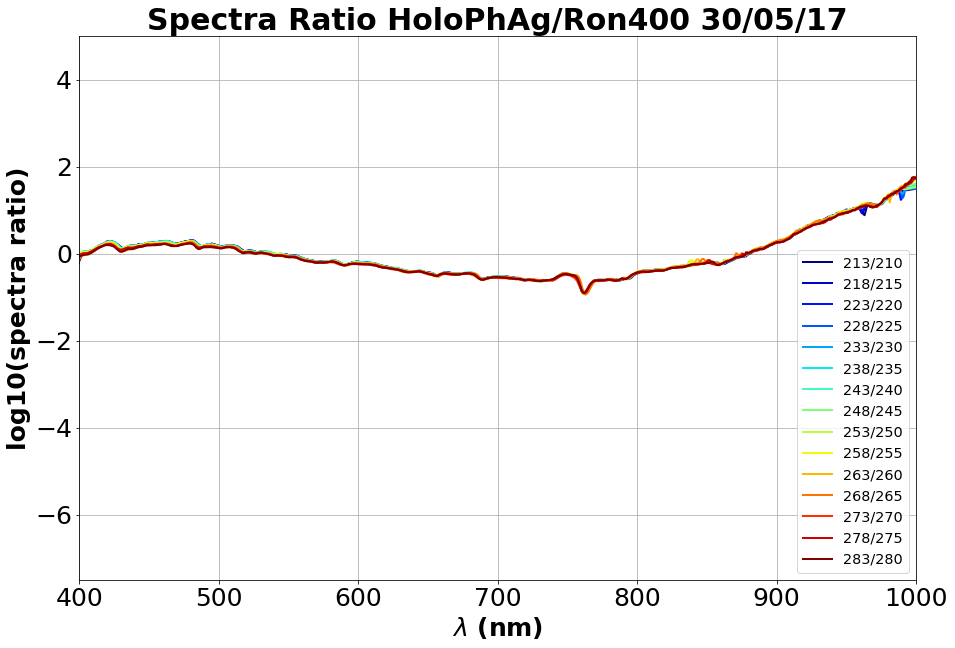

In [97]:
PlotSpectraRatio(HoloPhAg_Ron_indexes,sel2_obs,all_deltatime_HoloPhAg,
                 "Spectra Ratio HoloPhAg/Ron400 30/05/17",XMIN=400.,XMAX=1000.,YMIN=-7.5,YMAX=5,figfilename='HoloPhAgDivRon400.pdf',Flag_corr_wl=True)

/Users/dagoret/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/dagoret/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/dagoret/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:22: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/dagoret/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:23: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/dagoret/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:86: RuntimeWarning: divide by zero encountered in log10
/Users/dagoret/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:86: RuntimeWarning: invalid value encountered in subtract
2018-05-17 12:30:27,048 

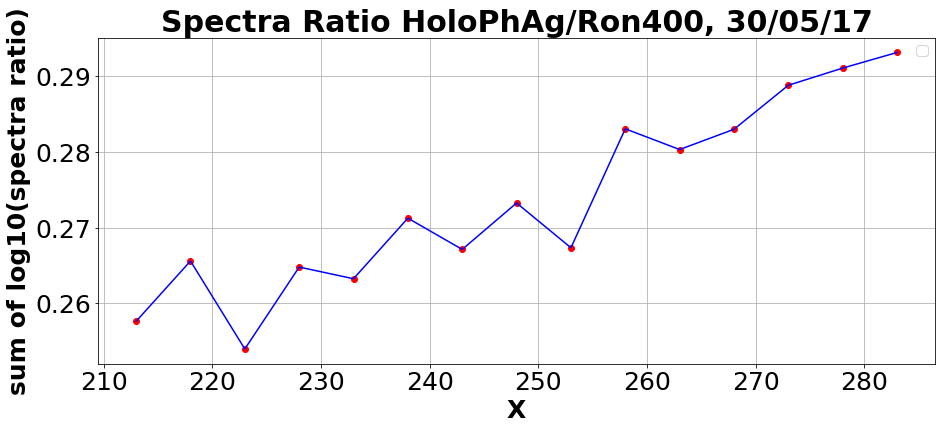

In [98]:
PlotSpectraRatioSum(HoloPhAg_Ron_indexes,sel2_obs,all_deltatime_HoloPhAg,
                 "Spectra Ratio HoloPhAg/Ron400, 30/05/17",figfilename='THoloPhAgDivRon400_idxtime_2.pdf',Flag_corr_wl=True)

/Users/dagoret/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/dagoret/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/dagoret/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:30: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/dagoret/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:31: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/dagoret/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:97: RuntimeWarning: invalid value encountered in divide


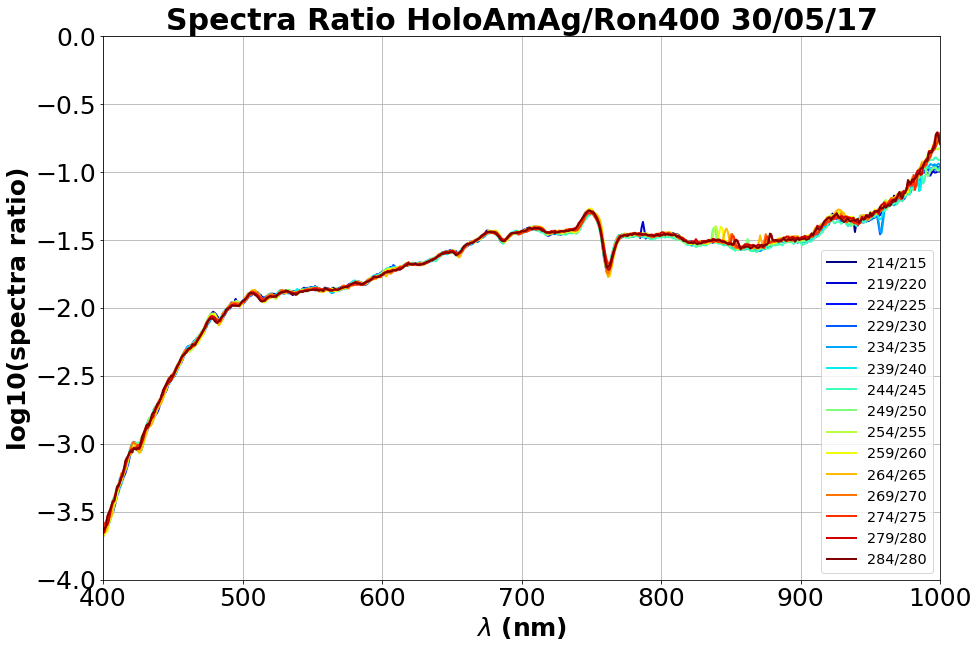

In [99]:
PlotSpectraRatio(HoloAmAg_Ron_indexes,sel2_obs,all_deltatime_HoloAmAg,
                 "Spectra Ratio HoloAmAg/Ron400 30/05/17",XMIN=400.,XMAX=1000.,YMIN=-4,YMAX=0,figfilename='HoloAmAgDivRon400.pdf',Flag_corr_wl=True)

/Users/dagoret/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/dagoret/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/dagoret/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:22: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/dagoret/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:23: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/dagoret/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:86: RuntimeWarning: divide by zero encountered in log10
/Users/dagoret/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:86: RuntimeWarning: invalid value encountered in subtract
2018-05-17 12:30:29,352 

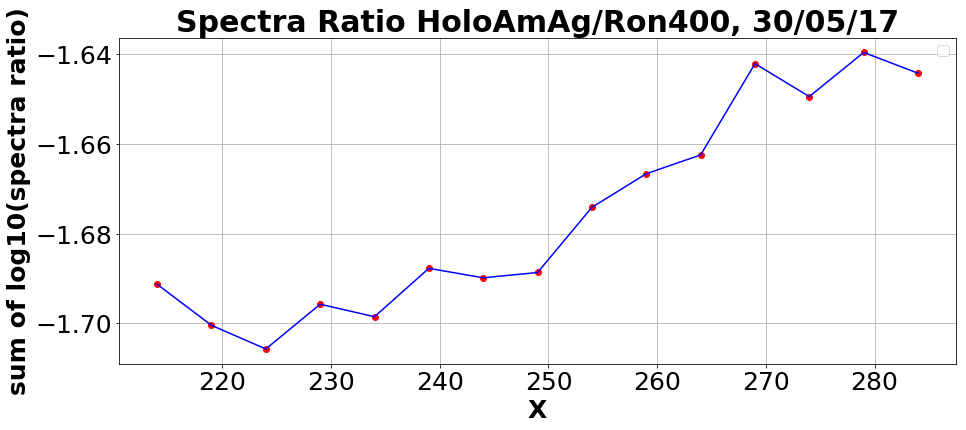

In [100]:
PlotSpectraRatioSum(HoloAmAg_Ron_indexes,sel2_obs,all_deltatime_HoloAmAg,
                 "Spectra Ratio HoloAmAg/Ron400, 30/05/17",figfilename='THoloAmAgDivRon400_idxtime_2.pdf',Flag_corr_wl=True)

## Ratio indexed by airmass